In [1]:
!pip install sentence_transformers
!pip install gensim
!pip install sklearn

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter

import gensim.downloader as api
from sentence_transformers import SentenceTransformer

import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from nltk import pos_tag, word_tokenize
from sklearn.preprocessing import OneHotEncoder

In [2]:
stoplist = set(stopwords.words('english'))

# vec_model = api.load("glove-wiki-gigaword-50")
# api.load("glove-twitter-50")
# vec_model['word']

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [3]:
df = pd.read_csv("../../data/narrativeqa_qas.csv")
df.describe()

n_samples = 40 
sample_df = df.sample(n_samples)

questions = sample_df.question
answers = sample_df.answer1

#questions.head()

In [4]:
q_words = set(['who','what','how','where','when','why','which','whom','whose', "who's"])
other_useful_terms = set([])

In [5]:
whitelist = q_words.union(stoplist).union(other_useful_terms)

q_contents = []
for row in questions:
    q_contents.append(" ".join([word for word in row.lower().split(" ") if word in whitelist]))
    #contents.append(" ".join([word for word in row.lower().split(" ")]))

In [6]:
print(Counter(contents).most_common(30))

NameError: name 'contents' is not defined

In [27]:
# Convert to sentence embeddings (maybe keep the indexes the same for future reference)
sentence_embeddings = []

#sentence_data = questions

sentence_data = answers
#sentence_data = q_contents

pos_tagged_data = np.array([pos_tag(word_tokenize(row))[1] for row in sentence_data])
print(pos_tagged_data[0])

[('After', 'IN'), ('Stuart', 'NNP'), ('opens', 'VBZ'), ('the', 'DT'), ('fuel', 'NN'), ('hatch', 'NN'), (',', ','), ('McClane', 'NNP'), ('lights', 'VBZ'), ('it', 'PRP'), ('on', 'IN'), ('fire', 'NN'), ('.', '.')]


In [33]:
one_hot = OneHotEncoder()

one = one_hot.fit_transform(pos_tagged_data.reshape(1, -1))

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['list']

In [ ]:
for i, row in enumerate(sentence_data):
    se = sbert_model.encode(row)
    sentence_embeddings.append(se)

In [45]:
# Cluster sentence embeddings
# The silhouette coefficients for each k
silhouette_coefficients = []

# The Within-Cluster-Sum-of-Squares for each k
wcss = []

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

ceil = 15

# Silhouette coefficient cannot work with less than 2 clusters
for k in range(2, ceil):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(sentence_embeddings)
    score = silhouette_score(sentence_embeddings, kmeans.labels_)
    silhouette_coefficients.append(score)
    wcss.append(kmeans.inertia_)

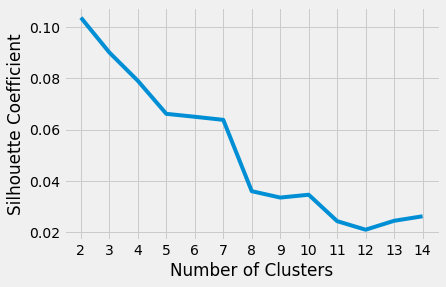

In [46]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, ceil), silhouette_coefficients)
plt.xticks(range(2, ceil))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

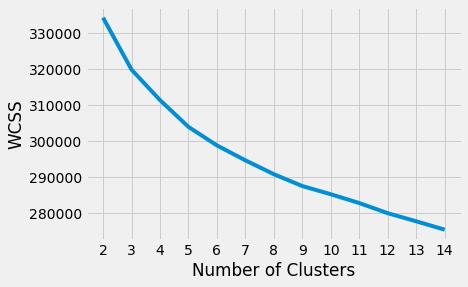

In [47]:
plt.plot(range(2, ceil), wcss)
plt.xticks(range(2, ceil))
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [48]:
# Off the basis of this second graph, 8 clusters should be used. 
n_clusters = 6
final_model = KMeans(n_clusters, **kmeans_kwargs)
final_model.fit(sentence_embeddings)

KMeans(init='random', n_clusters=6, random_state=42)

In [53]:
# labelled_contents = zip(contents[:500], final_model.labels_)
rdf = pd.DataFrame()
rdf['sentence'] = sentence_data[:n_samples]
rdf['label'] = final_model.labels_
# rdf['answer1'] = sample_df.answer1[:n_samples]
# rdf['answer2'] = sample_df.answer2[:n_samples]
rdf['question'] = sample_df.question[:n_samples]

rdf

,sentence,label,question
32677,Mr. and Mrs. Reeves,1,What are the names of Harriet's cousins?
27644,He gets glasses,3,How does Vaughn get better at pitching?
5268,Gale,1,Who attempts to stage a confrontation between ...
38379,He took an arrow from the statue of Tri-Miser...,2,What did Wesley use to stab Jessica with after...
36487,Auschwitz.,0,Where does Doork accidentally accompany the Je...
...,...,...,...
26571,"Scottsville, New York",5,Where is Sammy's childhood home located?
2362,He will only wrestle women.,2,"When Kaufman becomes a wrestler, what limitati..."
37329,She felt that he was too happy afterwards.,3,What made carol feel funny about Pauls reactio...
11021,By Hiccup's dragon Toothless who is being cont...,2,How is Hiccup's father killed?


In [59]:
rdf.loc[rdf['label'] == 5]

#print(contents[1000])

,sentence,label,question
31669,A lot of money.,5,What goes missing belonging to Louise's husband?
15822,South America,5,To what country does Juliet buy a plane ticket?
41004,The Hoover Dam,5,Where do the group gather ?
17820,his car,5,What does Steve let Toad borrow?
27570,A Catholic abbey,5,Where does Alleyne leave when he turns twenty-...
...,...,...,...
29738,catfish,5,What does will transform into at the end of hi...
35937,Cash drawers,5,What do the robbers raid during their robberies?
44378,A dugout,5,Where did Penrose take cover under shellfire?
31670,Four years.,5,How many years after Felipe's death passed by ...
